# Cross-slope section
** MODEL AGNOSTIC VERSION IN PROGRESS
Section through gridded data in ACCESS-OM2-01. We use the __[function](https://unidata.github.io/MetPy/latest/examples/cross_section.html#sphx-glr-examples-cross-section-py)__ `metpy.interpolate.cross_section` to do so. 
 Comparing temp, rho, S in cross-sections around Antarctica

Load modules

In [1]:
# Standard modules
import cosima_cookbook as cc
from cosima_cookbook import explore

from dask.distributed import Client
import numpy as np
import xarray as xr

# For gradient calculation 
# (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm

# Load metpy module to obtain cross section 
# (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm

In [2]:
from matplotlib import rc
rc('font', **{'size':25})

In [3]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Start a cluster with multiple cores

In [4]:
client = Client(local_directory = '/scratch/v45/qo9901/') 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34291/status,
Dashboard: /proxy/34291/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44049,Workers: 7
Dashboard: /proxy/34291/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:46725,Total threads: 4
Dashboard: /proxy/43245/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:39553,


Nominate a database from which to load the data and define an experiment

In [5]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'


In [6]:
depth = 3000

In [7]:
#Pick shelf coordinates
shelf_coord = (-62, -60+100)
deep_coord  = (-56.5, -59+100)


Load velocity and bathymetry data

In [8]:
# Select data in the southern Southern Ocean
lat_slice  = slice(-80, -59)
# We will use an annual average from one year in the RYF run

start_time='1950-01-31 00:00:00'
end_time='1959-12-31 00:00:00'

# Import bathymetry
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()


In [9]:
## importing density - ignore warnings
pot_rho_2 = cc.querying.getvar(expt, 'pot_rho_2', session,  start_time=start_time, end_time=end_time, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'})
pot_rho_2

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

<xarray.DataArray 'pot_rho_2' (time: 120, st_ocean: 75, yt_ocean: 2700,
                               xt_ocean: 3600)> Size: 350GB
dask.array<concatenate, shape=(120, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 960B 1950-01-16 12:00:00 ... 1959-12-16 12:00:00
Attributes:
    long_name:      potential density referenced to 2000 dbar
    units:          kg/m^3
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    ncfiles:        ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf90...
    contact:        Andy Hogg
    email:          andy.hogg@anu.edu.au
    created:        2020-06-11
    description:    0.1 degree ACCESS-OM2 global model configuration with JRA...
    notes:          Additional daily outputs saved from 1 Jan 1950 to 31 Dec ...
    url:            https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra5...

In [10]:
#importing potential temperature - ignore warnings
pot_temp =cc.querying.getvar(expt=expt, variable='pot_temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time=start_time, end_time=end_time)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [11]:
# Load model grid information with depth
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = xr.merge([pot_temp.sel(yt_ocean=lat_slice).sel(st_ocean=slice(0,depth)), grid.sel(yu_ocean=lat_slice).sel(yt_ocean=lat_slice)])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_depth = xgcm.Grid(ds, periodic=['X'])
grid_depth

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> outer
  * outer    yu_ocean --> center

Take time mean for density and temperature

In [12]:
pot_rho_2 = pot_rho_2.mean(dim = 'time')
pot_rho_2 = pot_rho_2.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
pot_rho_2

<xarray.DataArray 'pot_rho_2' (st_ocean: 60, yt_ocean: 483, xt_ocean: 3600)> Size: 417MB
dask.array<getitem, shape=(60, 483, 3600), dtype=float32, chunksize=(7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03

In [13]:
pot_temp = pot_temp.mean(dim = 'time')
pot_temp = pot_temp.sel(yt_ocean = lat_slice).sel(st_ocean=slice(0,depth))
pot_temp

<xarray.DataArray 'pot_temp' (st_ocean: 60, yt_ocean: 483, xt_ocean: 3600)> Size: 417MB
dask.array<getitem, shape=(60, 483, 3600), dtype=float32, chunksize=(7, 273, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -79.97 -79.93 -79.88 ... -59.08 -59.03
  * st_ocean  (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03

In [ ]:
#choosing number of steps in cross section
step_no = 400
# interpolation on to u grid
#pot_rho_2 = grid_depth.interp(grid_depth.interp(pot_rho_2, axis = 'X').chunk({'yt_ocean': 500}) , axis = 'Y', boundary = 'extend')#.sel(yu_ocean=lat_slice).sel(st_ocean=slice(0,depth))

# Create dataset
ds_pot_rho_2= xr.Dataset({"pot_rho_2": pot_rho_2, "lat": pot_rho_2.yt_ocean, "lon": pot_rho_2.xt_ocean})
# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_rho_2 = ds_pot_rho_2.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_rho_2['x'] = ds_pot_rho_2['x']+100
ds_pot_rho_2['x'].attrs = pot_rho_2['xt_ocean'].attrs

# MetPy parsing
pot_rho_2_parsed = ds_pot_rho_2.metpy.parse_cf('pot_rho_2', coordinates={'y': 'y', 'x': 'x'})
pot_rho_2_section = cross_section(pot_rho_2_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

In [16]:

# Create dataset
ds_pot_temp= xr.Dataset({"pot_temp": pot_temp, "lat": pot_temp.yt_ocean, "lon": pot_temp.xt_ocean})
# Interpolate to xu_ocean and yu_ocean
# Rename coordinate names
ds_pot_temp = ds_pot_temp.rename({'xt_ocean': 'x', 'yt_ocean': 'y'})
# Convert latitude from ACCESS-OM2 default range of [-280, 80] to [-180, 180] which is what metpy expects.
ds_pot_temp['x'] = ds_pot_temp['x']+100

ds_pot_temp['x'].attrs = pot_temp['xt_ocean'].attrs

# MetPy parsing
pot_temp_parsed = ds_pot_temp.metpy.parse_cf('pot_temp', coordinates={'y': 'y', 'x': 'x'})
pot_temp_section = cross_section(pot_temp_parsed, start=(shelf_coord[0], shelf_coord[1]), end=(deep_coord[0], deep_coord[1]), steps = step_no, interp_type='linear')

In [17]:
# load variables
pot_temp_section.load()
pot_rho_2_section.load()

<xarray.DataArray 'pot_rho_2' (st_ocean: 60, index: 400)> Size: 192kB
array([[1036.68270679, 1036.67410892, 1036.66325908, ...,           nan,
                  nan,           nan],
       [1036.68323595, 1036.67465944, 1036.66379814, ...,           nan,
                  nan,           nan],
       [1036.683867  , 1036.67532297, 1036.66447979, ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]])
Coordinates:
  * st_ocean   (st_ocean) float64 480B 0.5413 1.681 2.94 ... 2.659e+03 2.834e+03
    metpy_crs  object 8B Projection: latitude_longitude
    x          (index) float64 3kB 40.0 40.0 40.01 40.01 ... 41.0 41.0 41.0
    y          (index) float64 3kB -62.0 -61.99 -61.97 ... -56.53 -56.51 -56.5
  * index      (index) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399

Finally calculate the distance along the transect (for plotting purposes)

In [18]:
# Define number of points you want to interpolate
step_no = 400
# Radius of the Earth in km
r = 6371
# Difference between points in lat/lon space
dlon = deep_coord[1]-shelf_coord[1]
dlat = deep_coord[0]-shelf_coord[0]
# Calculate distance in km between the two end points
distance_endpoints = r * np.deg2rad(np.sqrt(dlat**2 + (dlon*np.cos(np.deg2rad(np.mean([shelf_coord[0],deep_coord[0]]))))**2))
# Create array with length of step_no
distance_in_km = np.linspace(0, distance_endpoints, step_no)
# Repeat by the number of depth levels
distance_in_km = np.tile(distance_in_km, (len(pot_temp_section.st_ocean), 1))

## Plotting cross-slope section of potential temperature

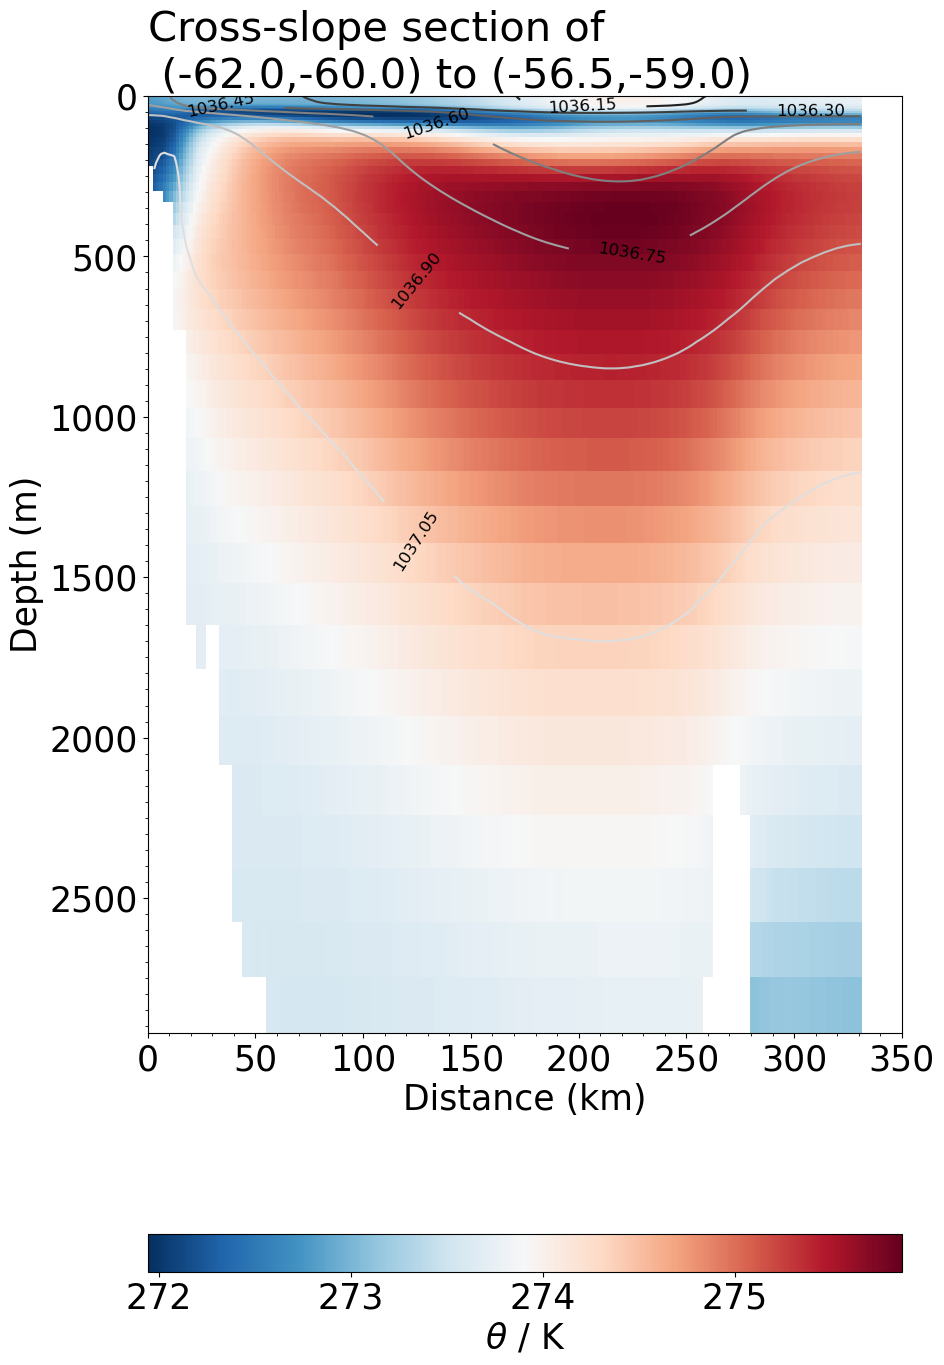

In [23]:
fig, axs = plt.subplots( figsize=(10, 15), sharex = True)
ft_size = 16

axs.set_title('Cross-slope section of \n (%.1f,%.1f) to (%.1f,%.1f)' % (shelf_coord[0],shelf_coord[1]-100,deep_coord[0],deep_coord[1]-100), loc='left')

cmesh = axs.pcolormesh(distance_in_km, pot_temp_section.st_ocean.sel(st_ocean=slice(0,5000)).values, pot_temp_section.sel(st_ocean=slice(0,5000)).values, cmap = 'RdBu_r')
# Colorbar
cbar = plt.colorbar(cmesh,orientation = 'horizontal')
cbar.set_label( r'$\theta$ / K')
#cbar.ax.tick_params(labelsize=ft_size)

cs = axs.contour(distance_in_km[0,:], pot_rho_2_section.st_ocean, pot_rho_2_section, cmap = 'gray')
axs.clabel(cs,cs.levels,fontsize = 12,colors = 'k', inline=True,inline_spacing=3)

# Axes
plt.gca().invert_yaxis()
plt.xlim([0,350])
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
axs.xaxis.set_minor_locator(MultipleLocator(10))
axs.yaxis.set_minor_locator(MultipleLocator(50))
plt.tight_layout()